In [180]:
import pandas as pd
import os
from baselines import evaluate_roc, find_threshold_for_sensitivity,find_threshold_for_specificity
import numpy as np
base_path = '../roc_analysis/ESAOTE_6100_test/'

patients = pd.read_pickle(os.path.join(base_path, 'patients.pkl'))
y_true = pd.read_csv(os.path.join(base_path, 'y_true.csv'))
records = pd.read_pickle(os.path.join(base_path, 'records.pkl'))
import seaborn as sns
import matplotlib.pyplot as plt

In [181]:
records['cramp'].value_counts()

cramp_5.3    23
cramp_2.2    20
cramp_1.1    19
cramp_5.1    16
cramp_5.0     9
cramp_5.4     7
cramp_3.0     6
cramp_3.1     4
cramp_5.2     3
cramp_3.3     2
cramp_1.6     2
cramp_3.5     1
cramp_4.1     1
cramp_3.8     1
cramp_5.5     1
cramp_4.5     1
cramp_4.4     1
Name: cramp, dtype: int64

In [182]:
pred_path = os.path.join(base_path,'proba','in_domain')
probas = []
for file in os.listdir(pred_path):
    if file.endswith('.csv'):
        proba = pd.read_csv(os.path.join(pred_path,file))
        proba = proba.pred
        name = file#file.split('.')[0]
       # proba.set_index(name)
        proba.rename(name, inplace=True)
        probas.append(proba)
        print(file)

probas = pd.DataFrame(probas)
probas = probas.transpose()

MIL-28_7_.csv
rulebased_original.csv
EI.csv
IMG-22_14_.csv
EIZ.csv
TASK-76_9_.csv


In [183]:
records['mean_EIZ'] = records['EIZ'].apply(lambda x: np.nanmean(x))

In [184]:
t = find_threshold_for_sensitivity(y_true, probas.iloc[:,1], 0.629)
t

Specificity obtained: 0.7610619469026548


0.5

In [185]:
def find_best_threshold_and_apply(proba_series, y_true):

    best_threshold = evaluate_roc(y_true,proba_series,'',False)
   
    binarized = (proba_series >= best_threshold).astype(int)
    return binarized

binarized = probas.apply(lambda x: find_best_threshold_and_apply(x, y_true['true']), axis=0)

Best threshold: < 0.507 --> negative
Recall = 0.795, Precision = 0.721
AUC: 0.75
Best threshold: < 0.507 --> negative
Recall = 0.795, Precision = 0.721
AUC: 0.75
Best threshold: < 1.0 --> negative
Recall = 0.624, Precision = 0.849
AUC: 0.765
Best threshold: < 0.52 --> negative
Recall = 0.803, Precision = 0.718
AUC: 0.786
Best threshold: < 0.66 --> negative
Recall = 0.778, Precision = 0.74
AUC: 0.783
Best threshold: < 0.565 --> negative
Recall = 0.718, Precision = 0.771
AUC: 0.786
Best threshold: < 0.696 --> negative
Recall = 0.573, Precision = 0.728
AUC: 0.713


In [186]:
def find_min_sens_threshold_and_apply(proba_series, y_true, sens):
    print(proba_series.name)
    t = find_threshold_for_sensitivity(y_true, proba_series, sens)
   
    binarized = (proba_series >= t).astype(int)
    
    return binarized

binarized = probas.apply(lambda x: find_min_sens_threshold_and_apply(x, y_true['true'],sens=0.629), axis=0)

MIL-28_7_.csv
Specificity obtained: 0.752212389380531
MIL-28_7_.csv
Specificity obtained: 0.752212389380531
rulebased_original.csv
Specificity obtained: 0.7610619469026548
EI.csv
Specificity obtained: 0.752212389380531
IMG-22_14_.csv
Specificity obtained: 0.7964601769911505
EIZ.csv
Specificity obtained: 0.8495575221238938
TASK-76_9_.csv
Specificity obtained: 0.6991150442477876


In [187]:
# corrs = probas.corr(method='spearman')

In [188]:
# error = probas.apply(lambda x: x - y_true['true'], axis=0)

In [189]:
binarized

,MIL-28_7_.csv,rulebased_original.csv,EI.csv,IMG-22_14_.csv,EIZ.csv,TASK-76_9_.csv
0,0,0,0,0,0,0
1,1,0,1,1,1,1
2,1,1,1,1,1,1
3,0,0,1,0,0,0
4,1,1,1,1,1,1
...,...,...,...,...,...,...
225,1,1,1,1,1,1
226,0,1,1,1,1,0
227,0,0,0,0,0,1
228,1,1,1,1,0,0


In [190]:
corrs = binarized.corr(method='spearman')

In [191]:
evaluate_roc(y_true, binarized.iloc[:,[0,1,3,4,5,6]].mode(axis=1)[0],'',False)

IndexError: positional indexers are out-of-bounds

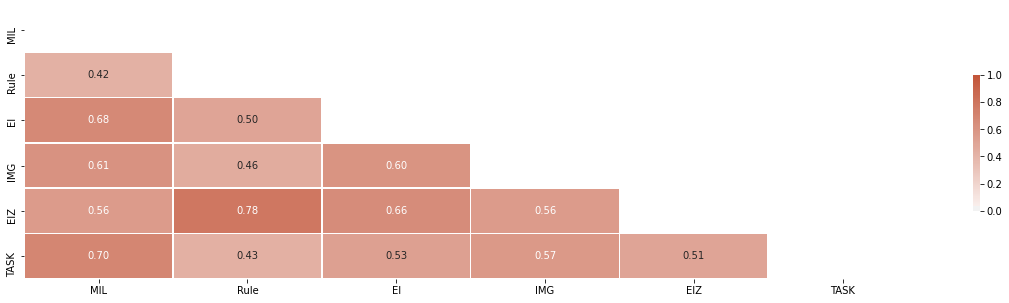

In [192]:
def format_name(name):
    name = name.split('.')[0]
    if '-' in name:
        name = name.split('-')[0]
    if 'rulebased' in name:
        name = 'Rule'
    return name
corrs.index = corrs.index.map(lambda x: format_name(x))
corrs.columns = corrs.columns.map(lambda x: format_name(x))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrs, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,fmt='.2f', annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})

In [193]:
error = binarized.apply(lambda x: x - y_true['true'], axis=0)

In [194]:
corrs.columns


Index(['MIL', 'Rule', 'EI', 'IMG', 'EIZ', 'TASK'], dtype='object')

In [195]:
error

,MIL-28_7_.csv,rulebased_original.csv,EI.csv,IMG-22_14_.csv,EIZ.csv,TASK-76_9_.csv
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
225,1.0,1.0,1.0,1.0,1.0,1.0
226,-1.0,0.0,0.0,0.0,0.0,-1.0
227,0.0,0.0,0.0,0.0,0.0,1.0
228,0.0,0.0,0.0,0.0,-1.0,-1.0


In [196]:
reduced = error

In [197]:
reduced = reduced.replace({0: 'correct', 1 : 'fp', -1 : 'fn'})

In [198]:
counts = reduced.apply(lambda x: x.value_counts(), axis =1)

In [199]:
counts['fp'].value_counts()

1.0    15
2.0    14
4.0    10
3.0     9
6.0     7
5.0     1
Name: fp, dtype: int64

In [200]:
all_missed = counts[counts['fn'] >= 6]

In [201]:
patients_missed = records.iloc[all_missed.index]

In [202]:
patients_missed['comment_naomi']

34                         Myopathy due to TPM3-mutation
38                                Small fibre neuropathy
62                           Radiculopathy S1 both sides
71                         Anti SRP necrotizing myopathy
87     Mitochondrial encephalopathy due to SDHA mutation
95                Trauma m. sternocleidomastoideus right
106                             Steroid induced myopathy
107                                      Myopathy e.c.i.
116                                 Myopathy due to LHON
118    RYR1-Related disease with exercise intolerance...
182                            Passed Radicular syndrome
184     Myopathy with polyglandular auto-immune syndrome
188                                  Congenital myopathy
196    Myopathy with TTN mutation with unknown pathog...
214    Myopathy due to mitochondrial disease due to N...
Name: comment_naomi, dtype: object

In [203]:
# recall by cramp group
import numpy as np
def get_cramp_root_level(cramp_string):
  if isinstance(cramp_string,str):
    cramp_number = cramp_string.split('_')[1]
    cramp_root = cramp_number.split('.')[0]
    return cramp_root

  return 0#np.nan
records['cramp_root'] = records['cramp'].apply(get_cramp_root_level)
records['cramp_root'] = records['cramp_root'].replace({np.nan : 'nan'})


In [204]:
merged_in = records.merge(right=binarized,left_index=True,right_index=True)

In [205]:
#agg_values = binarized.columns()
to_agg = binarized.columns.tolist()
#to_agg.append('mean_EIZ')
sens_by_cramp = merged_in.groupby('cramp_root').mean()[to_agg]

In [206]:
records['cramp_root'].value_counts()

0    113
5     59
1     21
2     20
3     14
4      3
Name: cramp_root, dtype: int64

In [207]:

#sens_by_cramp = merged_in.groupby('Age').mean()[to_agg]

In [208]:


sens_by_cramp.columns = sens_by_cramp.columns.map(lambda x: format_name(x))
sens_by_cramp = sens_by_cramp.reindex(sorted(sens_by_cramp.columns), axis=1)
sens_by_cramp['Frequency'] = records['cramp_root'].value_counts()

In [209]:
print(sens_by_cramp.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &   EI &  EIZ &  IMG &  MIL &  Rule &  TASK &  Frequency \\
cramp\_root &      &      &      &      &       &       &            \\
\midrule
0          & 0.25 & 0.15 & 0.20 & 0.25 &  0.24 &  0.30 &        113 \\
1          & 0.86 & 0.76 & 0.81 & 0.86 &  0.76 &  0.76 &         21 \\
2          & 0.45 & 0.40 & 0.45 & 0.40 &  0.65 &  0.50 &         20 \\
3          & 0.57 & 0.57 & 0.57 & 0.57 &  0.57 &  0.64 &         14 \\
4          & 1.00 & 0.67 & 1.00 & 1.00 &  0.67 &  1.00 &          3 \\
5          & 0.61 & 0.68 & 0.69 & 0.68 &  0.73 &  0.64 &         59 \\
\bottomrule
\end{tabular}



In [215]:
score_path = os.path.join(base_path, 'proba','in_domain','scores')
scores = []
for file in os.listdir(score_path):
    if file.endswith('.csv'):
        score_frame = pd.read_csv(os.path.join(score_path,file))
        name = file#file.split('.')[0]
       # proba.set_index(name)
       # score_frame.rename(name, inplace=True)
        scores.append(score_frame)
        print(file)

TASK-76_9_scores.csv
IMG-22_14_scores.csv
CORAL-133_7_scores.csv
MIL-28_7_scores.csv
MIL-59_9_scores.csv


In [217]:
scores[3]

,Unnamed: 0,Side,Muscle,Score,pid,EI,EIZ
0,0,L,Biceps brachii,0.047379,4502,62,-1.2
1,1,R,Biceps brachii,0.044864,4502,66,-0.7
2,2,L,Deltoideus,0.038208,4502,66,0.7
3,3,R,Deltoideus,0.046956,4502,58,-0.4
4,4,L,Flexor carpi radialis,0.045644,4502,49,-0.2
...,...,...,...,...,...,...,...
3214,11,R,Rectus femoris,0.010699,9975829,113,5.2
3215,12,L,Tibialis anterior,0.017764,9975829,92,1.0
3216,13,R,Tibialis anterior,0.077576,9975829,94,1.2
3217,14,L,Vastus lateralis,0.009481,9975829,115,4.3


In [250]:
def pad_pid(pid):
  pid_str = str(pid)
  diff = 7 - len(pid_str)
  filler = '0' * diff
  new_pid = filler + pid_str
  return new_pid

In [253]:
att_scores = scores[3]
att_scores['pid'] = att_scores['pid'].apply(pad_pid)

In [254]:
images_scores = scores[1]
images_scores['pid'] = att_scores['pid'].apply(pad_pid)

In [285]:
images_scores['Class'] = images_scores['pid'].apply(lambda x: records[records['pid'] == x].iloc[0]['Class'])
att_scores['Class'] = att_scores['pid'].apply(lambda x: records[records['pid'] == x].iloc[0]['Class'])

<ipython-input-248-502950d88fe8>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


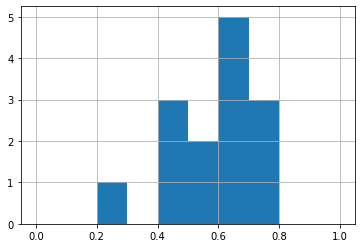

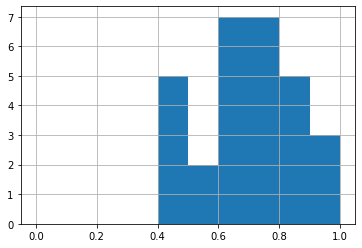

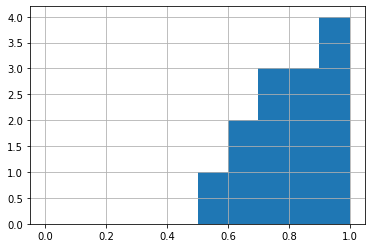

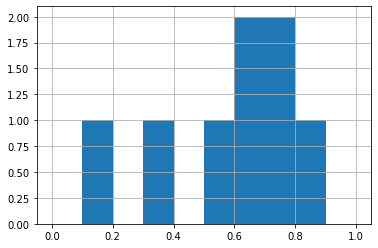

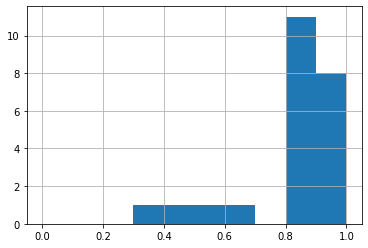

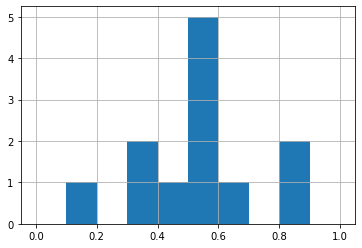

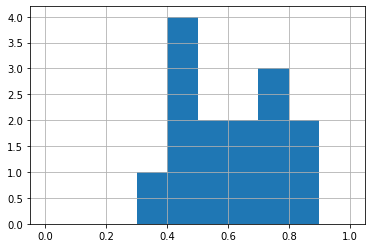

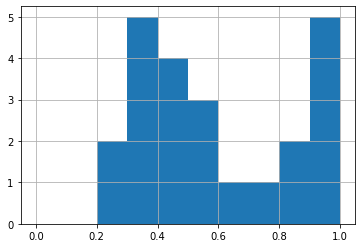

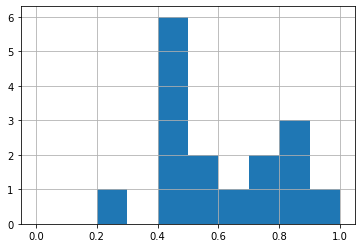

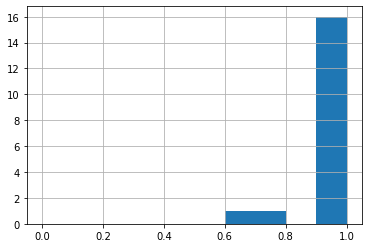

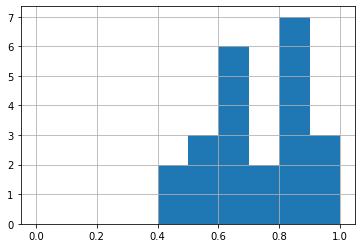

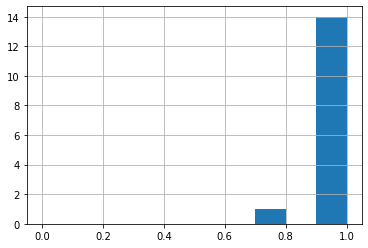

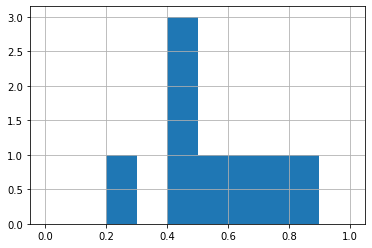

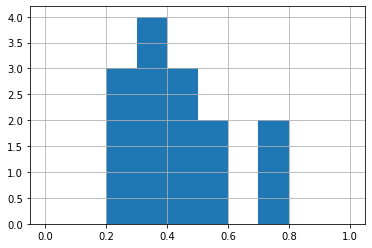

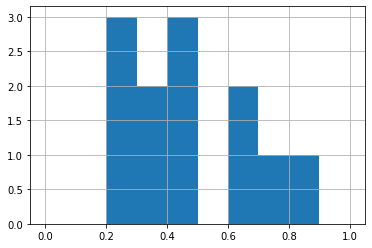

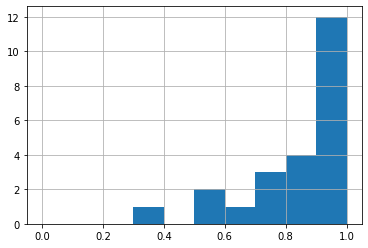

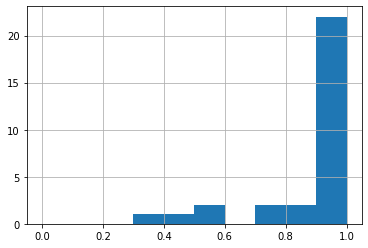

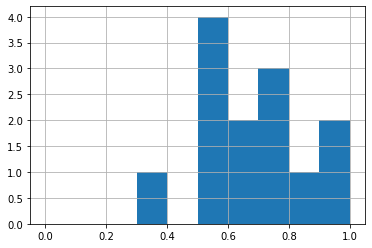

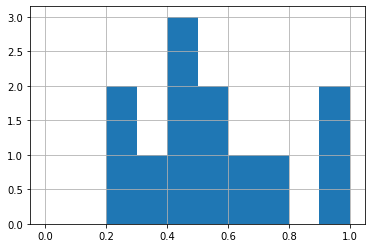

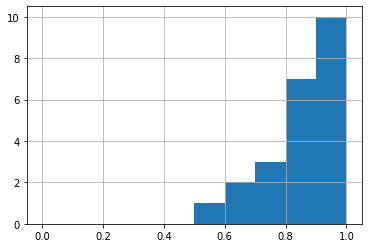

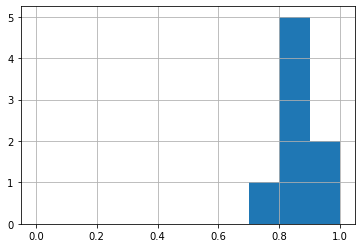

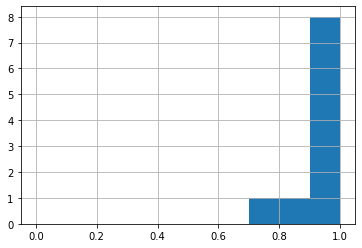

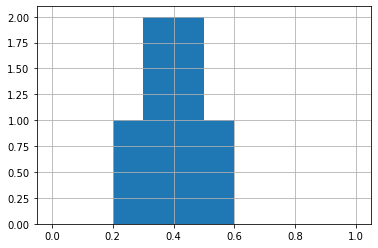

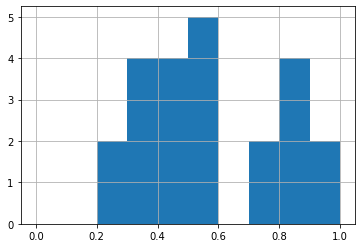

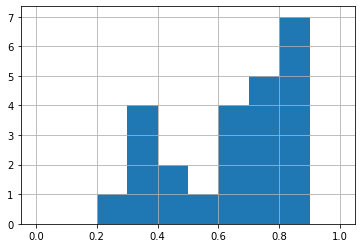

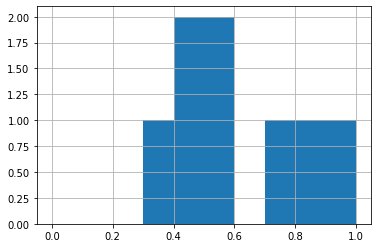

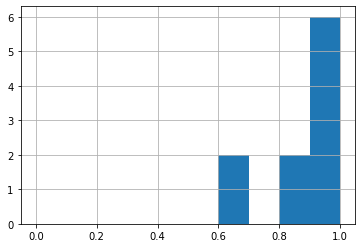

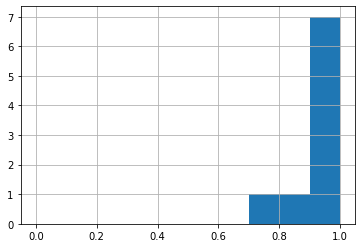

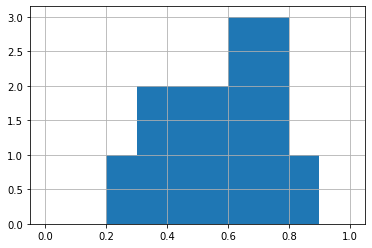

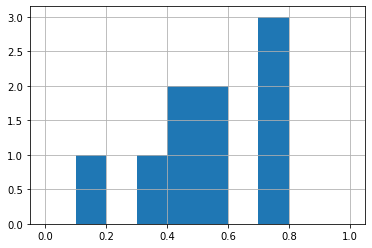

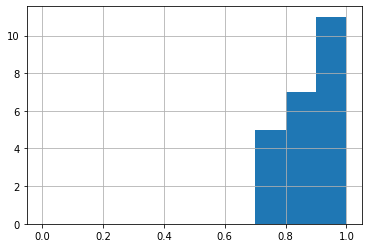

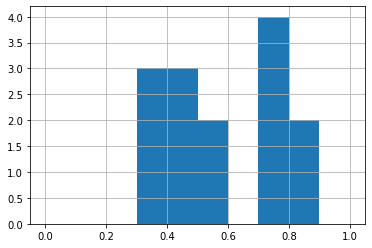

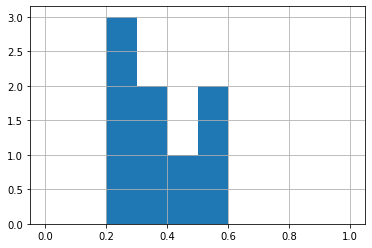

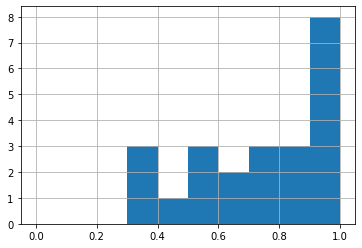

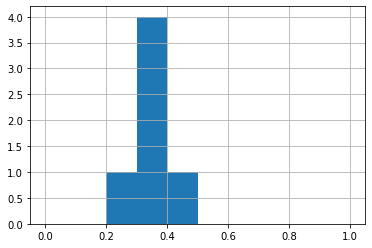

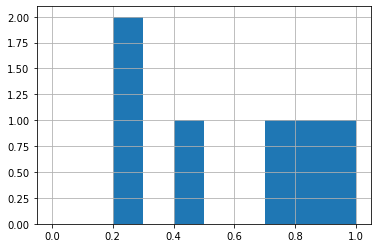

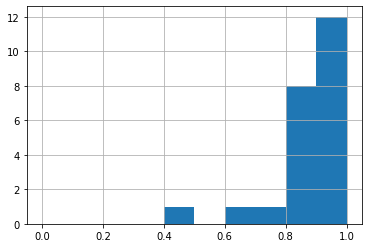

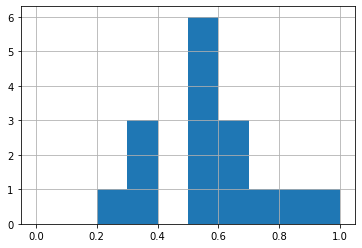

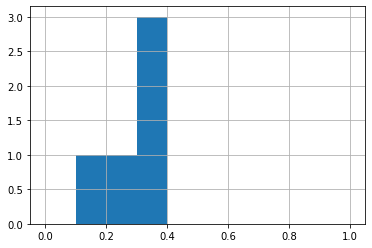

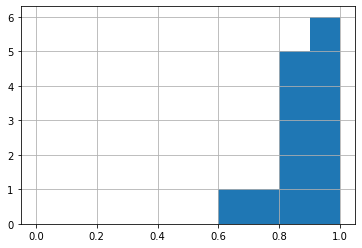

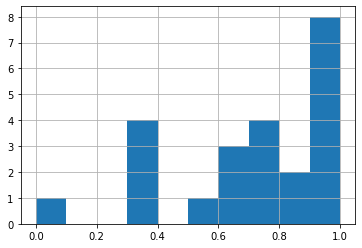

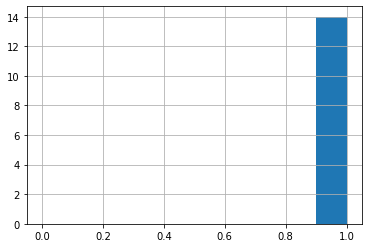

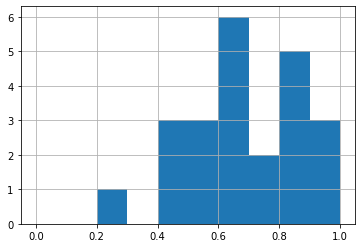

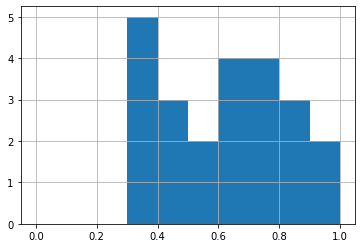

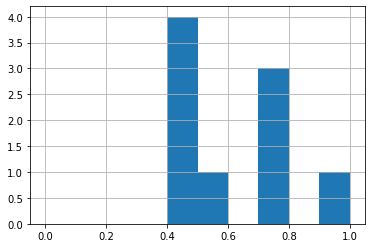

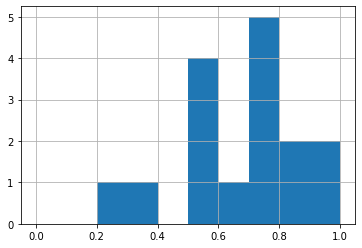

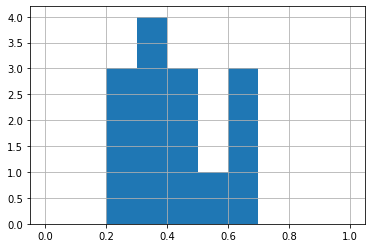

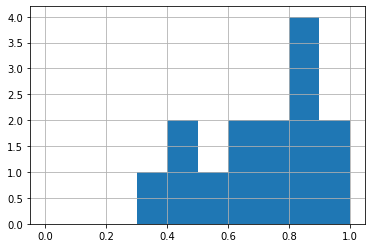

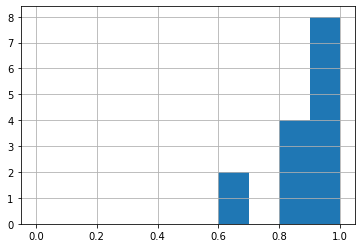

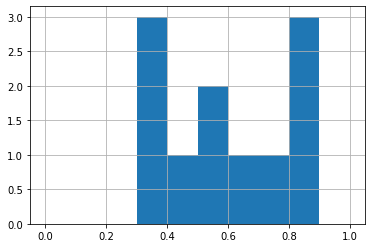

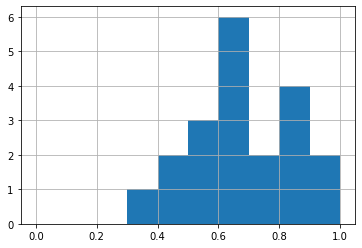

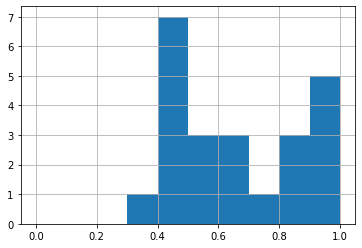

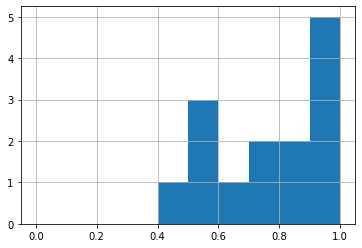

Error in callback <function flush_figures at 0x7fa8eeae0700> (for post_execute):


KeyboardInterrupt: 

In [248]:
bins = np.linspace(0,1,11)
for pid, group in scores[1].groupby('pid'):
    plt.figure()
    group['Score'].hist(bins=bins)

In [347]:
images_scores.groupby('Class').agg({'Score': ['min','max','median','mean', 'skew', 'var', compute_sse_from_mean]})

Score                                                    \
             min       max    median      mean      skew       var   
Class                                                                
NMD     0.098342  0.999975  0.816726  0.760465 -0.783305  0.040525   
no NMD  0.075236  0.998760  0.616867  0.613782 -0.033401  0.049038   

                              
       compute_sse_from_mean  
Class                         
NMD                 0.040504  
no NMD              0.049002

In [359]:
from sklearn.metrics import mean_squared_error

def compute_sse_from_mean(vec):
    mean_vec= [1 / len(vec)] * len(vec)
    return mean_squared_error(vec,mean_vec) 
att_scores.groupby('Class').agg({'Score': ['min','max','median','mean', 'skew', 'var', compute_sse_from_mean]})

Score                                                    \
             min       max    median      mean      skew       var   
Class                                                                
NMD     0.007715  0.589725  0.047304  0.062656  2.346113  0.002447   
no NMD  0.011060  0.411468  0.068127  0.082286  1.617258  0.002913   

                              
       compute_sse_from_mean  
Class                         
NMD                 0.006304  
no NMD              0.009561

In [334]:
import scipy
import random
aal = np.random.uniform(low=0,high=1,size=1000)
scipy.stats.kstest(rvs=aal,cdf='uniform')

KstestResult(statistic=0.023617799643734783, pvalue=0.6237026604950224)

In [339]:
scipy.stats.kstest(rvs=att_scores[att_scores['pid'] == '0004502']['Score']
,cdf='uniform')

KstestResult(statistic=0.8658424913883209, pvalue=1.2292460853199447e-12)

In [353]:
from sklearn.metrics import mean_squared_error

vec = [0.2,0.4,0.2]
mean_vec= [np.mean(vec)] * len(vec)
mean_squared_error(vec,mean_vec)

0.008888888888888889

In [360]:
att_scores.groupby('pid').agg({'Score': compute_sse_from_mean, 'Class': max}).groupby('Class').mean()

,Score
Class,
NMD,0.001871
no NMD,0.002235


In [368]:
exp_dict = (1 / att_scores.groupby('pid').count()['Score']).to_dict()

In [369]:
att_scores['diff_from_expected'] = att_scores.apply(lambda x : x['Score'] - exp_dict[x['pid']],axis=1)

In [374]:
att_scores.corr()

,Unnamed: 0,Score,EI,EIZ,diff_from_expected
Unnamed: 0,1.000000,-0.131825,0.226179,0.028373,0.216145
Score,-0.131825,1.000000,0.179805,0.162151,0.754680
EI,0.226179,0.179805,1.000000,0.768399,0.294325
EIZ,0.028373,0.162151,0.768399,1.000000,0.205491
diff_from_expected,0.216145,0.754680,0.294325,0.205491,1.000000


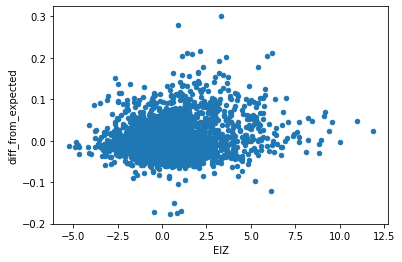

In [381]:
att_scores.plot('EIZ','diff_from_expected','scatter')

In [386]:
import plotly.express as px
px.scatter(att_scores,x='EI',y='diff_from_expected',color='Class')

In [392]:
total_score_sums = images_scores.groupby('pid').sum()['Score']
images_scores['normalized_score'] = images_scores.apply(lambda x: x['Score'] / total_score_sums[x['pid']],axis=1)

In [395]:
exp_dict = (1 / images_scores.groupby('pid').count()['Score']).to_dict()
images_scores['diff_from_expected'] = images_scores.apply(lambda x : x['normalized_score'] - exp_dict[x['pid']],axis=1)
#exp_dict = (1 / att_scores.groupby('pid').count()['Score']).to_dict()

In [397]:
px.scatter(images_scores,x='EI',y='diff_from_expected',color='Class')

In [462]:
tester = pd.DataFrame([att_scores['diff_from_expected'], images_scores['diff_from_expected'],images_scores['EIZ']],['Score_diff_MIL','Score_diff_IMG','EIZ'])

In [463]:
tester =  tester.transpose()

In [464]:
tester.corr()

,Score_diff_MIL,Score_diff_IMG,EIZ
Score_diff_MIL,1.000000,0.212984,0.205491
Score_diff_IMG,0.212984,1.000000,0.133344
EIZ,0.205491,0.133344,1.000000


In [465]:
import plotly.figure_factory as ff

In [466]:
fig = ff.create_scatterplotmatrix(tester, diag='histogram',height=800,width=800, title='Score analysis')

In [467]:
fig.show()